In [32]:
import json
from collections import Counter
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import ssl
import numpy as np 
import seaborn as sns
import random
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer 
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/volthai7us/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
def clean_and_split(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return words

def preprocess_speaker(speaker): 
    file_path = f'./data/transcripts/friends-1-227-{speaker}-pair.json'

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
        
    all_answers = [item['answer'] for item in data]

    all_answers = [clean_and_split(answer) for answer in all_answers]

    stop_words = set(stopwords.words('english'))
    
    
    def remove_stopwords(answer):
        filtered_words = [word for word in answer if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    all_answers = [remove_stopwords(answer) for answer in all_answers]

    return all_answers

In [50]:
speakers = ("Rachel", "Chandler", "Phoebe", "Monica", "Ross", "Joey")

all_data = []

for index, speaker in enumerate(speakers):
    all_answers = preprocess_speaker(speaker=speaker)
    speaker_data = [(answer, index) for answer in all_answers]
    sample_size = min(2000, len(speaker_data))
    random_sample = random.sample(speaker_data, sample_size)
    all_data.extend(random_sample)
    
speaker_combinations = []

for speaker1 in speakers:
    for speaker2 in speakers:
        combination = f"{speaker1}-{speaker2}"
        speaker_combinations.append(combination)

df = pd.DataFrame(all_data, columns=['text', 'speaker'])
df = df.sample(frac=1)



In [51]:
docs = list(df['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [52]:
X = docs 
y = df['speaker']
print(X.shape, y.shape)

(12000, 6782) (12000,)


In [53]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [54]:
def train_and_test(X, y, model=GaussianNB):
    print("-" * 50)
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

    m = model
    # print("Model: ", model.__name__)
    %time m.fit(X_train, y_train)

    y_pred_train = m.predict(X_train)
    y_pred_test = m.predict(X_test)
    print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
    print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
    
    print(classification_report(y_test, y_pred_test, target_names=speakers))
    
    cm = confusion_matrix(y_test, y_pred_test, normalize='true')
    # print('Confusion matrix\n', cm)

    cm_matrix = pd.DataFrame(data=cm, columns=speakers, index=speakers)
    sns.heatmap(cm_matrix, annot=True , cmap='YlGnBu')
    plt.show()

In [55]:
from sklearn.neural_network import MLPClassifier

--------------------------------------------------
CPU times: user 256 ms, sys: 29.8 ms, total: 286 ms
Wall time: 285 ms

Training Accuracy score: 0.648125
Testing Accuracy score: 0.23666666666666666
              precision    recall  f1-score   support

      Rachel       0.25      0.29      0.27       400
    Chandler       0.20      0.27      0.23       400
      Phoebe       0.24      0.20      0.22       400
      Monica       0.25      0.23      0.24       400
        Ross       0.24      0.20      0.22       400
        Joey       0.25      0.23      0.24       400

    accuracy                           0.24      2400
   macro avg       0.24      0.24      0.24      2400
weighted avg       0.24      0.24      0.24      2400



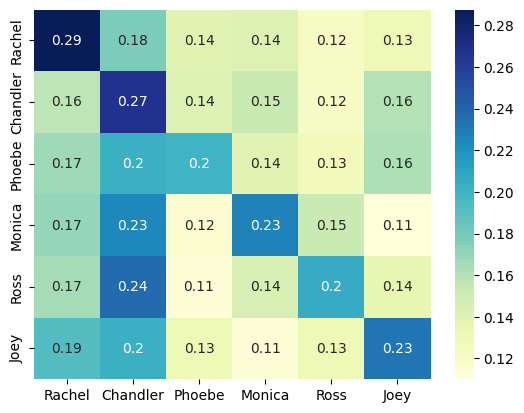

In [58]:
train_and_test(X=X, y=y, model=LinearSVC())